# *Emotion Detection Using MobileNetV2 CNN*

In [28]:
!unzip "/content/FER 13 Facial Expression dataset.zip"


Archive:  /content/FER 13 Facial Expression dataset.zip
replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness


In [4]:
import os

# List folders to verify
os.listdir('/content')

['.config',
 'train',
 'FER 13 Facial Expression dataset.zip',
 'test',
 '.ipynb_checkpoints',
 'sample_data']

In [5]:
IMG_SIZE=(96, 96)

In [6]:
# Define paths
train_dir = "/content/train"
test_dir = "/content/test"

# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",          # or "categorical" for one-hot
    image_size=IMG_SIZE,     # Resize images
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=True
)


Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)


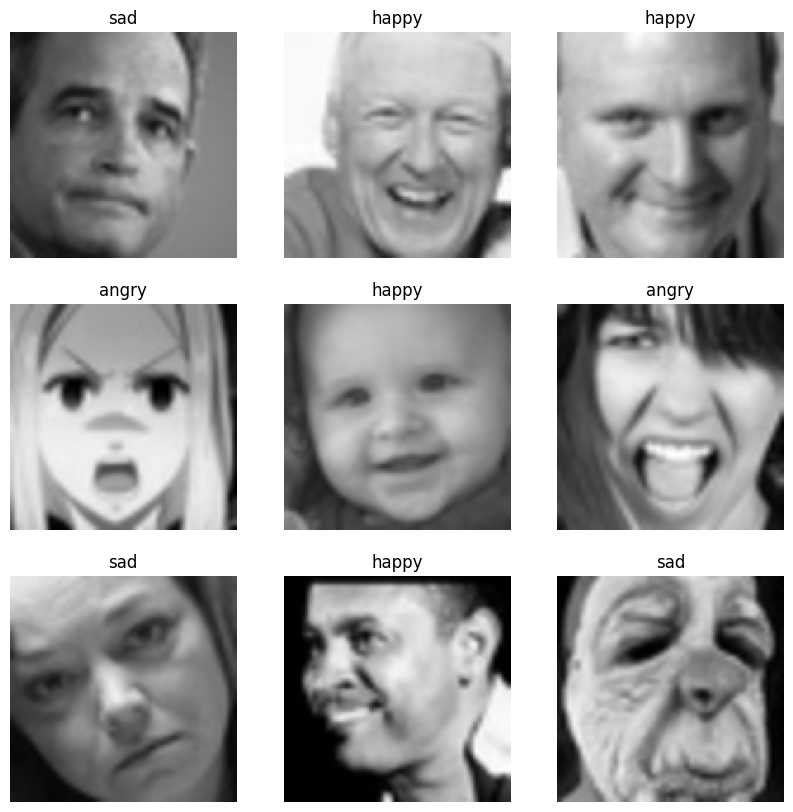

In [7]:
class_names=train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3, 3, i+1)
    print(images[i].shape)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
train_dataset=train_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
def augumenter():
  data_augumentation=tf.keras.Sequential()
  data_augumentation.add(RandomFlip('horizontal'))
  data_augumentation.add(RandomRotation(0.2))
  data_augumentation.add(RandomZoom(0.1))
  data_augumentation.add(RandomBrightness(0.1))

  return data_augumentation

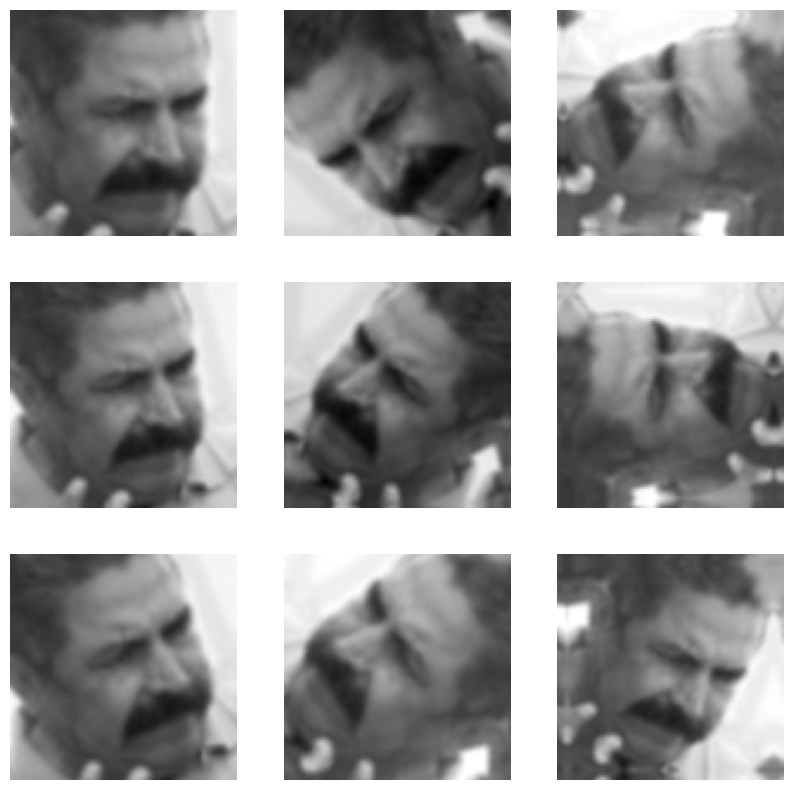

In [10]:
data_augumentation=augumenter()
for image,_ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image=image[0]
  for i in range(9):
    ax=plt.subplot(3, 3, i+1)
    augumented_image=data_augumentation(tf.expand_dims(first_image, 0))
    plt.imshow(augumented_image[0]/255)
    plt.axis("off")



In [11]:
preprocess_input=tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
def face_model(image_shape=IMG_SIZE, data_augumentation=augumenter()):
  input_shape=image_shape+(3, )
  base_model=tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                              include_top=False,
                                              weights='imagenet')
  base_model.trainable=False
  inputs=tf.keras.Input(shape=input_shape)

  x=data_augumentation(inputs)
  x=preprocess_input(x)
  x=base_model(x, training=False)
  x=tfl.GlobalAveragePooling2D()(x)
  x=tfl.Dropout(0.2)(x)

  prediction_layer=tfl.Dense(units=7, activation='softmax')
  outputs=prediction_layer(x)

  model=tf.keras.Model(inputs, outputs)

  return model


In [13]:
model1=face_model(IMG_SIZE, data_augumentation)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
base_learning_rate=0.001
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [16]:
initial_epochs=5
history1=model1.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=initial_epochs)

Epoch 1/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.3048 - loss: 1.9182 - val_accuracy: 0.3853 - val_loss: 1.5588
Epoch 2/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.3746 - loss: 1.6471 - val_accuracy: 0.4042 - val_loss: 1.5698
Epoch 3/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.3867 - loss: 1.6040 - val_accuracy: 0.4142 - val_loss: 1.5255
Epoch 4/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.3900 - loss: 1.5947 - val_accuracy: 0.3966 - val_loss: 1.5522
Epoch 5/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.3915 - loss: 1.5909 - val_accuracy: 0.4193 - val_loss: 1.5158


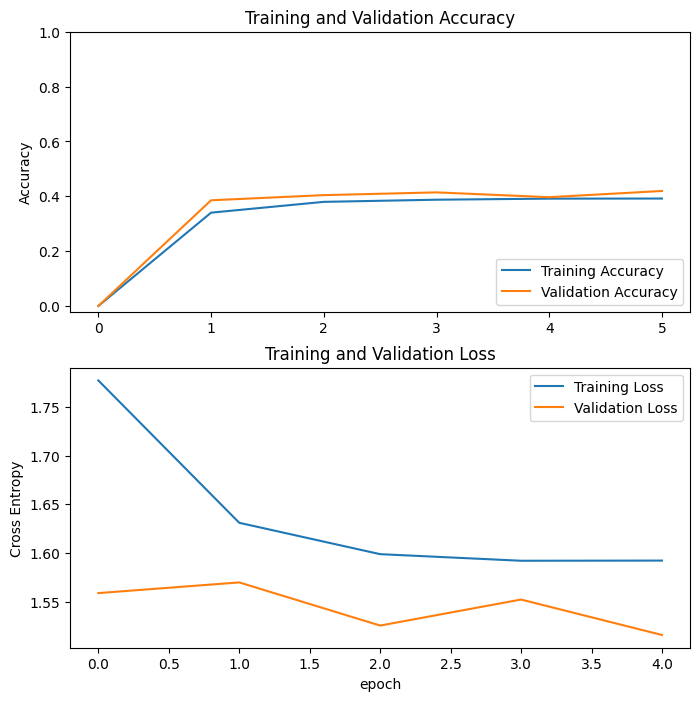

In [37]:
acc = [0.] + history1.history['accuracy']
val_acc = [0.] + history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
for i, layer in enumerate(model1.layers):
    print(i, layer.name, type(layer))


0 input_layer_2 <class 'keras.src.layers.core.input_layer.InputLayer'>
1 sequential <class 'keras.src.models.sequential.Sequential'>
2 mobilenetv2_1.00_96 <class 'keras.src.models.functional.Functional'>
3 global_average_pooling2d <class 'keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>
4 dropout <class 'keras.src.layers.regularization.dropout.Dropout'>
5 dense <class 'keras.src.layers.core.dense.Dense'>


In [18]:
base_model = model1.layers[2]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)
# Use accuracy as evaluation metric
metrics=['accuracy']

model1.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [19]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model1.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history1.epoch[-1],
                         validation_data=test_dataset)

Epoch 5/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.3653 - loss: 1.7750 - val_accuracy: 0.4551 - val_loss: 1.6914
Epoch 6/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - accuracy: 0.4744 - loss: 1.3710 - val_accuracy: 0.5003 - val_loss: 1.3859
Epoch 7/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.5148 - loss: 1.2659 - val_accuracy: 0.5490 - val_loss: 1.2014
Epoch 8/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.5430 - loss: 1.2047 - val_accuracy: 0.5727 - val_loss: 1.1554
Epoch 9/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.5581 - loss: 1.1622 - val_accuracy: 0.5607 - val_loss: 1.1677
Epoch 10/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - accuracy: 0.5727 - loss: 1.1251 - val_accuracy: 0.5819 - val_loss: 1.1311
Epoch 11/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - accuracy: 0.5885 - loss: 1.0875 - val_accuracy: 0.5924 - val_loss: 1.1166
Epoch 12/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.6010 - loss: 1.0591

In [38]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

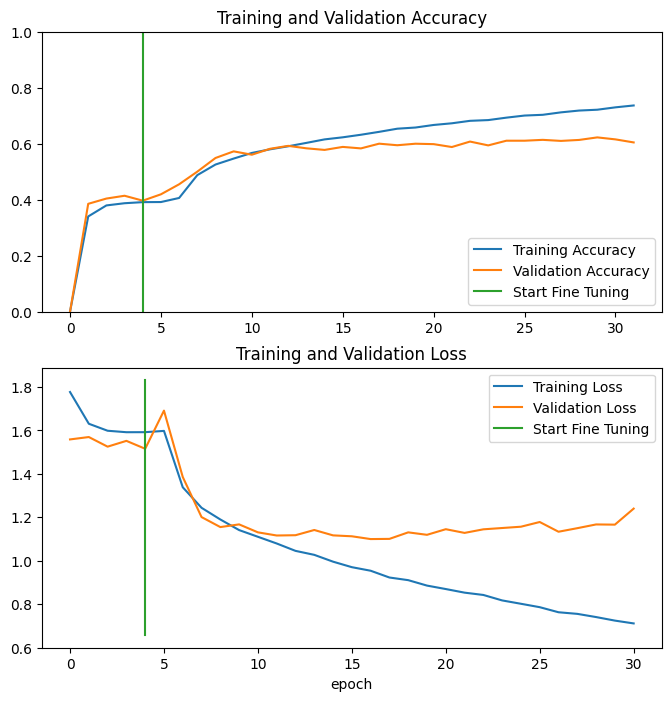

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
model.save('emotion_model.keras')